In [1]:
from IPython.display import clear_output

# Download Files

In [2]:
# ! rm -rf VisDrone_CenterNet
! git clone https://github.com/HungryCookie/VisDrone_CenterNet

fatal: destination path 'VisDrone_CenterNet' already exists and is not an empty directory.


## Loading train dataset

In [3]:
# ! mkdir '/content/VisDrone_CenterNet/data/coco/'
# ! unzip -o 'drive/My Drive/public/train.zip' -d '/content/VisDrone_CenterNet/data/coco/'
# clear_output()

! wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1yCaQQQfxYobfzDfirgcTeyO38Qg7cPv4' -O train.zip
! unzip -o './train.zip' -d '/content/VisDrone_CenterNet/data/coco/'
clear_output()

## Loading test dateset

In [3]:
! wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1eYUiFH6FVX9V3SFxFjZP2wjTqoCMV9uA' -O val.zip
! unzip -o './val.zip' -d '/content/VisDrone_CenterNet/data/coco/'
clear_output()

## Loading best model

In [4]:
! wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1CYIKuh5U_8ObdlDZ2cuizKDdOCatGEvG' -O best.zip
! unzip -o "./best.zip"
clear_output()

## Loading test results

In [5]:
! wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1wX-Oxl73YsmBfr0k16V3EpZVP1BxaW4h' -O results_val.zip
! unzip -o "./results_val.zip"
clear_output()

## Install additional packages

In [6]:
! pip install progress
clear_output()

# Train

Using GPU is highly preferred

In [ ]:
! nvidia-smi

Sun Sep 27 13:25:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# ! python ./VisDrone_CenterNet/src/main.py

In [ ]:
! cd VisDrone_CenterNet/src/lib/external/ && make

python setup.py build_ext --inplace
Compiling nms.pyx because it changed.
[1/1] Cythonizing nms.pyx
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/VisDrone_CenterNet/src/lib/external/nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'nms' extension
creating build
creating build/temp.linux-x86_64-3.6
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I/usr/include/python3.6m -c nms.c -o build/temp.linux-x86_64-3.6/nms.o -Wno-cpp -Wno-unused-function
x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fstack-protector-strong -Wformat -We

# Make predictions

`test.py` runs model over all passed files and writes predictions to `CENTER_NET/exp/results.json`

In [ ]:
# ! cd ./VisDrone_CenterNet/src/ && python test.py

In [ ]:

# ! cd ./VisDrone_CenterNet/src/ && \
# python demo.py

# Visualization
Visualization of predicted results from ```$CENTER_NET/srs/test.py```

Download prepared results.json (or use yours)

In [7]:
! wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1zZANLzw1LRXJ5d4LeoZ-hetNL1maVhBj' -O results.zip
! unzip -o './results.zip'
clear_output()

In [8]:
%matplotlib inline

import torch
import json
import cv2

from collections import defaultdict
from matplotlib import pyplot as plt

## Support methods

In [9]:
def read_files(predictions, annotations):
    '''
    params:
        @predictions - .json file with predictions
        @annotations - .json file with annotations in COCO format
    -----------
        @preds - list of dicts of all predictions
        @annos - dict of COCO format annotations
    '''
    with open(predictions, 'r') as file:
        preds = json.load(file)
    with open(annotations, 'r') as file:
        annos = json.load(file)
    print('Predicted: {}, Original: {}'.format(len(preds), len(annos['annotations'])))
    return preds, annos

In [10]:
def draw_bboxes(image, bboxes, colors=[], ground_truth=False):
    '''
    params:
        @image - read image in np.array format
        @bboxes - list of bboxes to draw
    ------------
        @draw - image with drawn bboxes
    '''
    draw = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    for bbox, class_id in bboxes:
        if not ground_truth and class_id in (1, 12):
            continue
        if colors:
          if ground_truth:
            color = colors[class_id - 1]
          else:
            color = colors[class_id - 2]
        else:
          color = (255, 0, 0)
        draw = cv2.rectangle(draw, (int(bbox[0]), int(bbox[1])), 
                              (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), 
                              color, 2)
    return draw

## Prediction vs Ground Truth Visualization

In [11]:
def show_detections(predictions, annotations):
    '''
    params:
        @predictions - list of dicts of all predictions
        @annotations - dict of COCO format annotations
    '''
    num_classes = 10
    VISDRONE_LABELS = {
        0: "Pedestrian",
        1: "People",
        2: "Bicycle",
        3: "Car",
        4: "Van",
        5: "Truck",
        6: "Tricycle",
        7: "Awning-tricycle",
        8: "Bus",
        9: "Motor",
    }

    colors = [
      (255, 255, 255),
      (255, 0, 0),
      (255, 128, 0),
      (51, 255, 255),
      (0, 255, 0),
      (255, 255, 0),
      (255, 0, 127),
      (102, 51, 0),
      (0, 128, 255),
      (128, 128, 128)
    ]
    # colors = [(v // 32 * 64 + 64, (v // 8) % 4 * 64, v % 8 * 32) for v in range(1, num_classes + 1)]
    for c in range(num_classes):
      print(f"classs {VISDRONE_LABELS[c]}: {colors[c - 1]}")
    
    img_paths = dict()
    for image in annotations['images']:
        img_paths[str(image['id'])] = image['file_name']

    # Convert predictions and annotations into dict where
    # image_id is a key
    predicted_bboxes = defaultdict(list)
    for pred in predictions:
        predicted_bboxes[pred['image_id']].append({'category_id': pred['category_id'],
                                              'bbox': pred['bbox'], 
                                              'score': pred['score']})
    annotation_bboxes = defaultdict(list)
    for anno in annotations['annotations']:
        annotation_bboxes[anno['image_id']].append({'category_id': anno['category_id'],
                                              'bbox': anno['bbox']})

    for pred in predicted_bboxes.keys():
        bboxes = [(x['bbox'], x['category_id']) for x in predicted_bboxes[pred]]
        gt_bboxes = [(x['bbox'], x['category_id']) for x in annotation_bboxes[pred]]
        # print(f'Predicted Bboxes are {bboxes}')
        # print(f'GT Bboxes are {gt_bboxes}')

        image_path = img_paths[str(pred)]
        show_single_detection(image_path, gt_bboxes, bboxes, colors)

def show_single_detection(image_path, gt_bboxes, pred_bboxes, colors):
    image = cv2.imread(image_path)
    predicted_image = draw_bboxes(image, pred_bboxes, [])
    gt_image = draw_bboxes(image, gt_bboxes, [], ground_truth=True)

    # Draw predictions and ground truth
    fig = plt.figure(figsize=(18, 18))
    ax1 = fig.add_subplot(1,2,1)
    ax1.title.set_text('Ground Truth')
    ax1.imshow(gt_image)
    ax2 = fig.add_subplot(1,2,2)
    ax2.title.set_text('Predicted')
    ax2.imshow(predicted_image)
    plt.show()



In [12]:
import sys
sys.path.insert(0, "/content/VisDrone_CenterNet/src/lib")

import os
from datasets.dataset_factory import dataset_factory
from detectors.detector_factory import detector_factory
from opts import opts
import argparse
from progress.bar import Bar
from utils.utils import AverageMeter

def run_test():
    Dataset = dataset_factory["coco"]

    opt = opts().parse(["ctdet", "--load_model", "/content/model_best.pth", "--head_conv", "64", "--not_prefetch_test"])
    opt = opts().update_dataset_info_and_set_heads(opt, Dataset)

    Detector = detector_factory[opt.task]
    dataset = Dataset(opt, "test")
    detector = Detector(opt)

    results = {}
    dataset_len = len(dataset)

    bar = Bar("{}".format(opt.exp_id), max=dataset_len)
    time_stats = ["tot", "load", "pre", "net", "dec", "post", "merge"]
    avg_time_stats = {t: AverageMeter() for t in time_stats}

    for ind in range(dataset_len):
        img_id = dataset.images[ind]
        img_info = dataset.coco.loadImgs(ids=[img_id])[0]
        img_path = os.path.join(dataset.img_dir, img_info["file_name"])
        
        ret = detector.run(img_path)

        results[img_id] = ret["results"]

        Bar.suffix = "[{0}/{1}]|Tot: {total:} |ETA: {eta:} ".format(
            ind, dataset_len, total=bar.elapsed_td, eta=bar.eta_td
        )
        for t in avg_time_stats:
            avg_time_stats[t].update(ret[t])
            Bar.suffix = Bar.suffix + "|{} {:.3f} ".format(t, avg_time_stats[t].avg)
        bar.next()
    bar.finish()
    dataset.save_results(results, "/content")
  # dataset.run_eval(results, opt.save_dir)


NMS not imported! If you need it, do 
 cd $CenterNet_ROOT/src/lib/external 
 make
NMS not imported! If you need it, do 
 cd $CenterNet_ROOT/src/lib/external 
 make


In [ ]:
run_test()

In [14]:
annotations_path = '/content/VisDrone_CenterNet/data/coco/validation/vis_val.json'
predictions_path = './results_val_DCN.json'

# preds, annos = read_files('./results.json', # /content/VisDrone_CenterNet/exp/ctdet/default
#                           '/content/VisDrone_CenterNet/data/coco/validation/vis_val.json')
preds, annos = read_files(predictions_path, annotations_path)


Predicted: 54800, Original: 38759


classs Pedestrian: (128, 128, 128)
classs People: (255, 255, 255)
classs Bicycle: (255, 0, 0)
classs Car: (255, 128, 0)
classs Van: (51, 255, 255)
classs Truck: (0, 255, 0)
classs Tricycle: (255, 255, 0)
classs Awning-tricycle: (255, 0, 127)
classs Bus: (102, 51, 0)
classs Motor: (0, 128, 255)


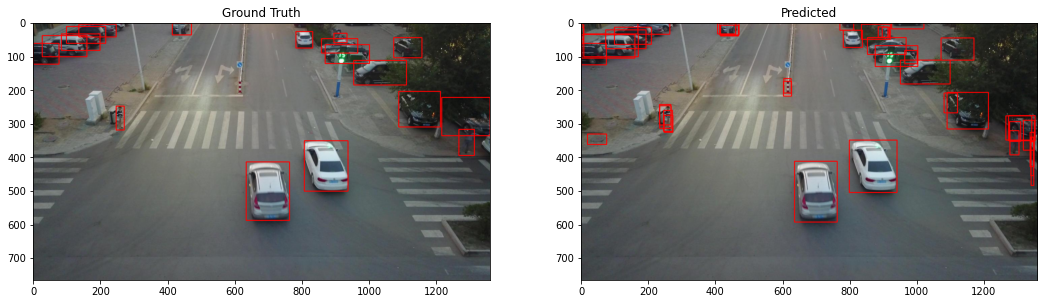

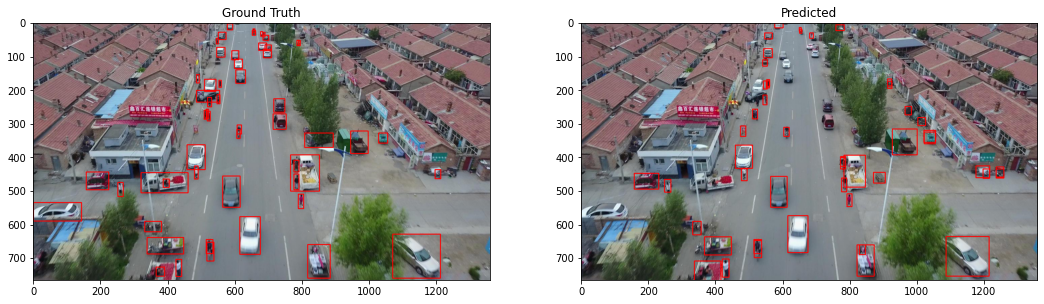

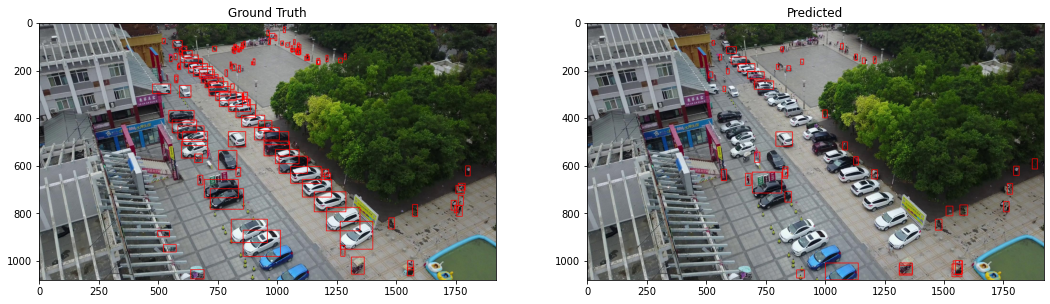

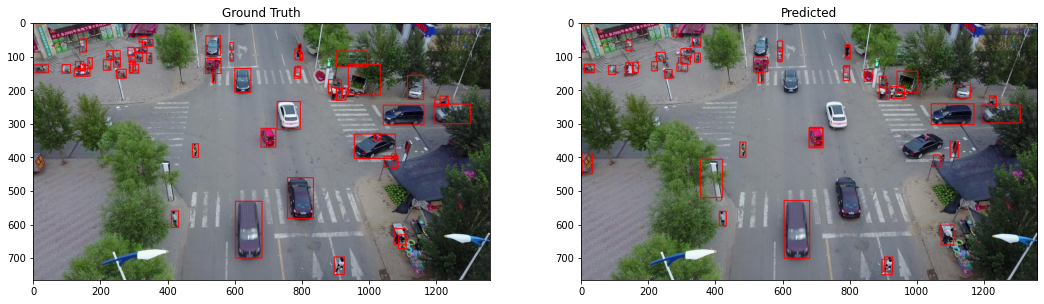

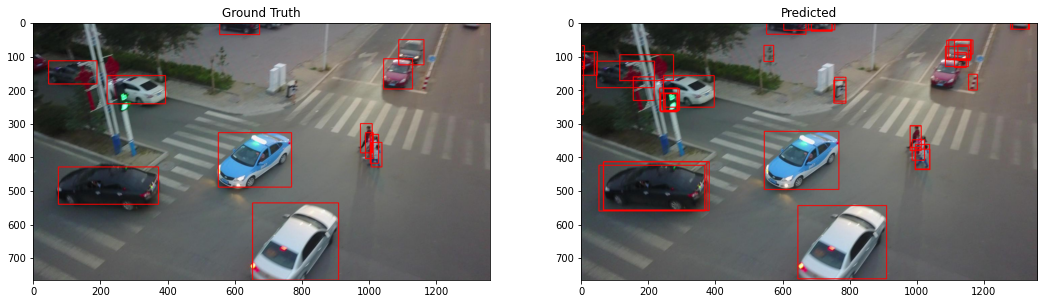

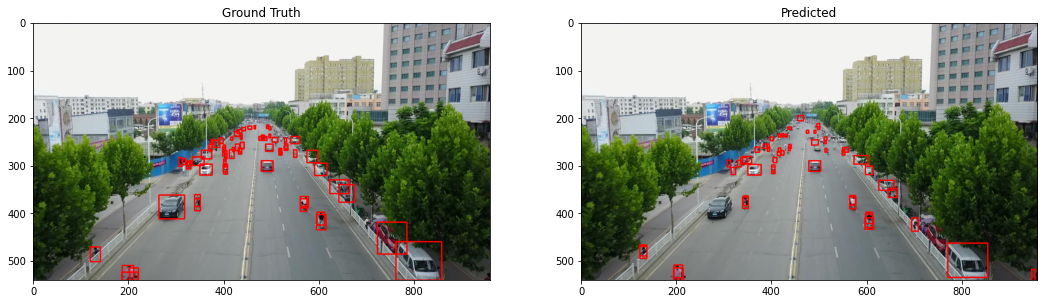

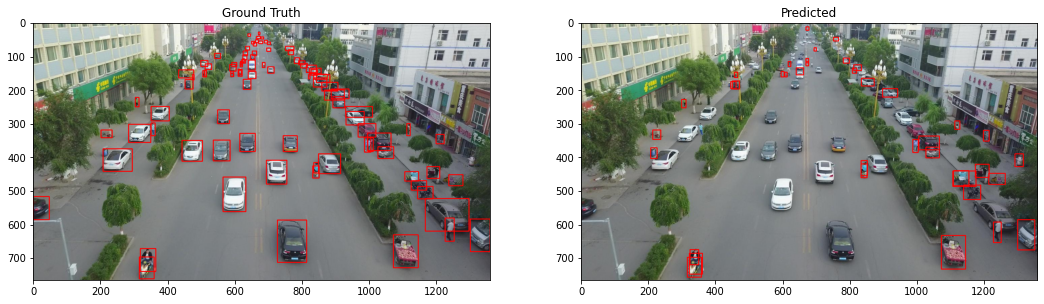

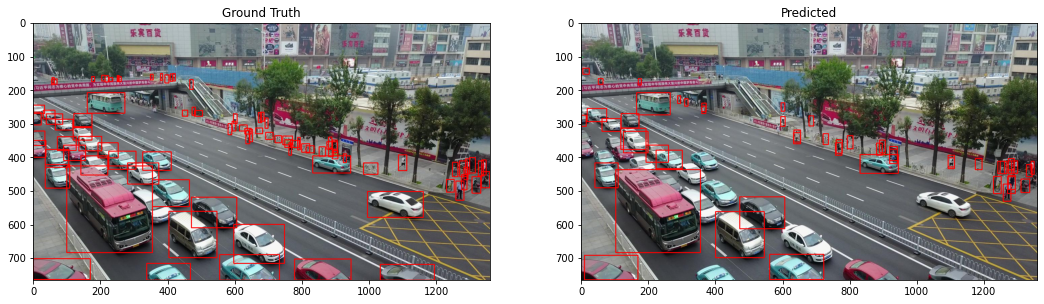

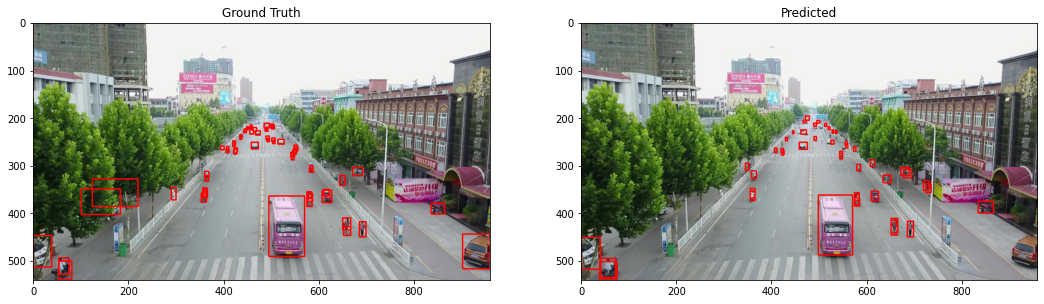

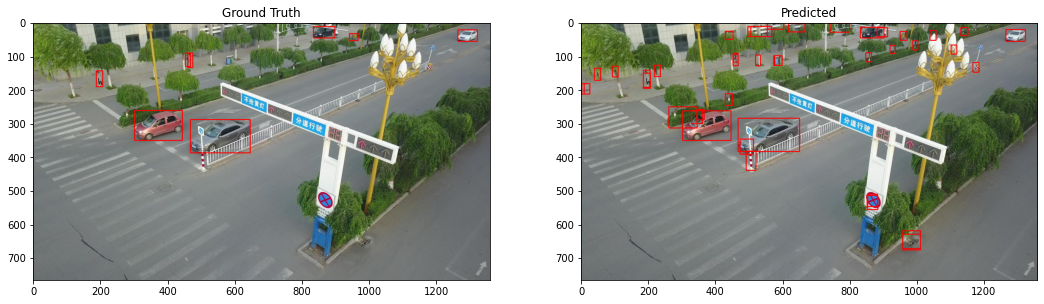

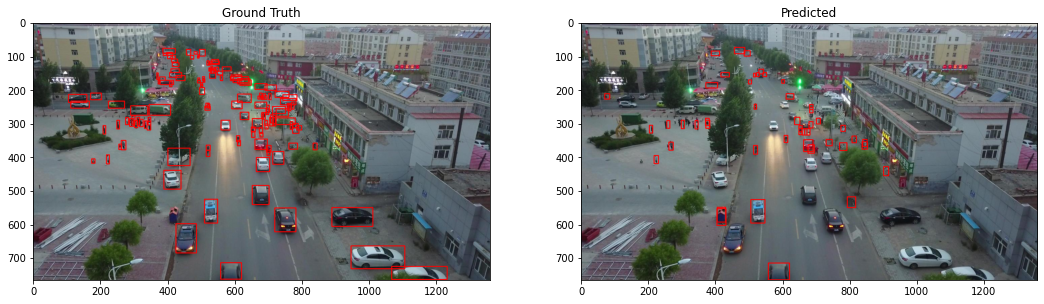

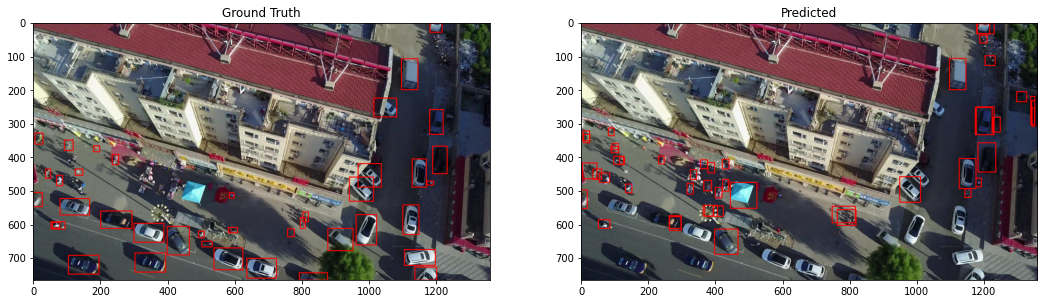

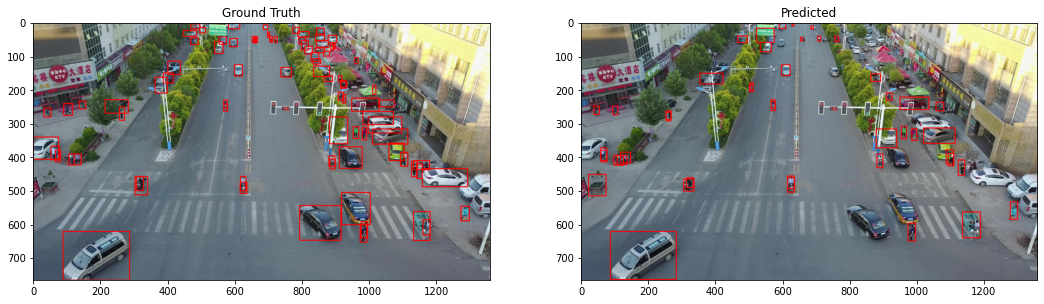

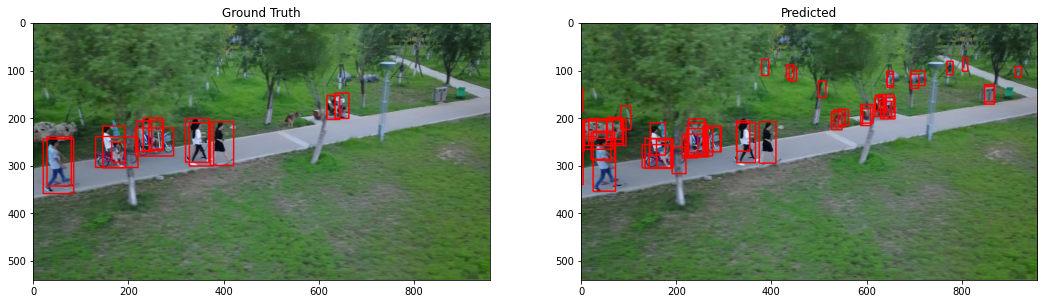

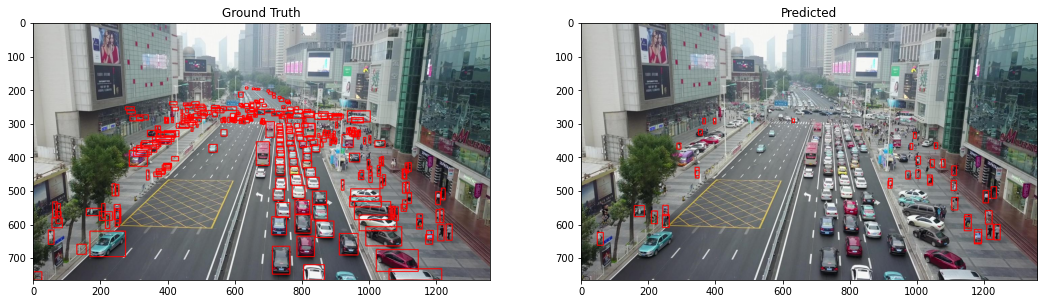

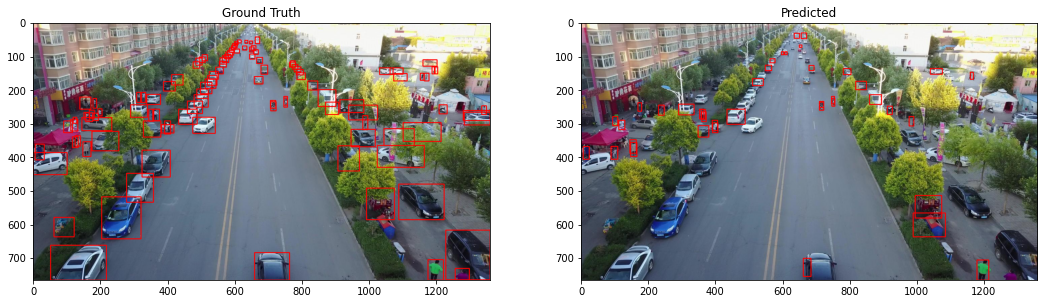

KeyboardInterrupt: ignored

In [15]:
show_detections(preds, annos)